In [5]:
import json
import numpy as np
import pandas as pd
import os
import scipy.signal as signal
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay

# mapeamento das classes
model_classes = {
    "SGDClassifier": SGDClassifier,
    "MLPClassifier": MLPClassifier
}

base_path = r'C:\Users\ferna\Documents\Unisinos\Cadeiras\TCC 2\Dataset utilizado\GalaxyPPG\Dataset'

# Lista manual com os IDs dos participantes escolhidos
selected_ids = ['P11', 'P12', 'P13', 'P14', 'P15', 'P17', 'P18', 'P19', 'P20']

# Lista para armazenar os DataFrames
dataframes = []

# Itera sobre os IDs e carrega cada arquivo
for participant_id in selected_ids:
    ppg_path = os.path.join(base_path, participant_id, 'GalaxyWatch', 'PPG.csv')
    
    if os.path.exists(ppg_path):
        df = pd.read_csv(ppg_path)
        df['participant_id'] = participant_id  # Adiciona a origem dos dados
        dataframes.append(df)
    else:
        print(f"[Aviso] Arquivo não encontrado: {ppg_path}")

# Concatena todos os dados em um único DataFrame
df_centralizado = pd.concat(dataframes, ignore_index=True)

# Exibe resultado
print(f"[Info] Dados centralizados com sucesso. Total de registros: {len(df_centralizado)}!")
print(df_centralizado.head())

ppg_signal = df_centralizado['ppg'].values     # Extrai o sinal PPG (fotopletismografia)
ppg_ts = df_centralizado['timestamp'].values   # Extrai os timestamps (não usado diretamente)
fs = 25  # Frequência de amostragem do sinal (25 Hz)

def butter_lowpass(data, cutoff=5, fs=25, order=3):
    nyq = 0.5 * fs  # Frequência de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)  # Filtro passa-baixa aplicado em modo zero-phase (sem atraso)
    return y

ppg_filtered = butter_lowpass(ppg_signal, cutoff=5, fs=fs, order=3)

# 3. Função para extrair features HRV a partir dos picos detectados
def extract_hrv_features_from_peaks(peaks, fs):
    try:
        if len(peaks) < 3:
            raise ValueError("Poucos picos detectados para análise HRV")

        # Calcula os intervalos entre batimentos (IBI) em segundos
        ibis = np.diff(peaks) / fs
        ibis_ms = ibis * 1000  # Converte para milissegundos

        # Cálculo das métricas HRV
        rmssd = np.sqrt(np.mean(np.square(np.diff(ibis_ms))))       # Raiz da média dos quadrados das diferenças consecutivas
        sdnn = np.std(ibis_ms)                                       # Desvio padrão dos intervalos
        pnn50 = np.sum(np.abs(np.diff(ibis_ms)) > 50) / len(ibis_ms) # Proporção de diferenças maiores que 50ms
        mean_ibi = np.mean(ibis_ms)                                  # Média dos intervalos
        iqr_ibi = np.percentile(ibis_ms, 75) - np.percentile(ibis_ms, 25)  # Intervalo interquartil

        return [rmssd, sdnn, pnn50, mean_ibi, iqr_ibi]
    except Exception as e:
        print(f"Erro no cálculo HRV: {e}")
        return [np.nan] * 5

# 4. Extração das features com janela móvel
window_size = 30 * fs  # Janela de 30 segundos
step_size = 10 * fs    # Passo de 10 segundos (sobreposição de 20 segundos)

features = []
labels = []

# Extraindo features HRV e definindo rótulo de anormalidade cardíaca
for start in range(0, len(ppg_filtered) - window_size, step_size):
    segment = ppg_filtered[start:start + window_size]

    # Detecta picos no segmento com distância mínima de 0.5s entre eles (ajustável)
    peaks, _ = find_peaks(segment, distance=int(fs * 0.5))

    # Ignora segmentos com poucos picos detectados (não confiável para análise)
    if len(peaks) < 3:
        continue

    # Extrai as métricas HRV a partir dos picos detectados
    hrv = extract_hrv_features_from_peaks(peaks, fs)

    # Ignora segmentos com métricas inválidas (NaN)
    if np.any(np.isnan(hrv)):
        continue

    rmssd, sdnn = hrv[0], hrv[1]

    # Define o label binário (0 = normal, 1 = possível anormalidade)
    label = int((rmssd < 20) or (sdnn < 50))

    features.append(hrv)
    labels.append(label)

# Converte listas para arrays NumPy
X = np.array(features)
y = np.array(labels)

# 5. Normalização e divisão treino-validação-teste
scaler = StandardScaler()
Xs_test = scaler.fit_transform(X) 

print("\nTratamento dos dados concluído!")

[Info] Dados centralizados com sucesso. Total de registros: 864000!
    dataReceived      timestamp      ppg  status participant_id
0  1711437352342  1711437340286  2097152       0            P11
1  1711437352342  1711437340327  2097152       0            P11
2  1711437352342  1711437340369  2462981       0            P11
3  1711437352342  1711437340408  2462958       0            P11
4  1711437352342  1711437340447  2462983       0            P11

Tratamento dos dados concluído!


In [6]:
def find_best_threshold(model, X, y, metric="f1", thr_range=(0.0, 1.0), steps=101):
    """
    Busca o melhor threshold para classificação binária.

    Params:
        model: modelo treinado (precisa ter predict_proba ou decision_function)
        X: features de teste
        y: rótulos verdadeiros
        metric: métrica a otimizar ("f1", "accuracy", "precision", "recall")
        thr_range: intervalo de busca dos thresholds (default 0.0 a 1.0)
        steps: número de pontos testados no intervalo

    Return:
        best_thr (float), best_score (float)
    """

    # Probabilidades ou scores
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
    else:
        y_prob = model.decision_function(X)

    # Escolha da métrica
    metrics_map = {
        "f1": f1_score,
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
    }
    scorer = metrics_map.get(metric.lower(), f1_score)

    best_thr, best_score = 0.5, -1
    for thr in np.linspace(thr_range[0], thr_range[1], steps):
        y_pred_thr = (y_prob >= thr).astype(int)
        score = scorer(y, y_pred_thr)
        if score > best_score:
            best_thr, best_score = thr, score

    return best_thr, best_score

# Regressão logística(LR)


Regressão logística centralizado:
Melhor threshold: 0.76, com F1: 0.9726
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2479
           1       0.98      0.97      0.97       974

    accuracy                           0.98      3453
   macro avg       0.98      0.98      0.98      3453
weighted avg       0.98      0.98      0.98      3453

Acurácia: 0.9847

Matriz de Confusão:
[[2460   19]
 [  34  940]]


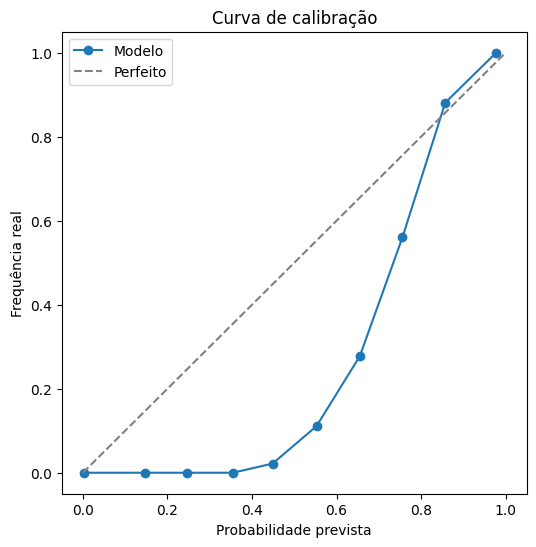


Regressão logística federado:
Melhor threshold: 0.60, com F1: 0.9617
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2479
           1       0.97      0.95      0.96       974

    accuracy                           0.98      3453
   macro avg       0.98      0.97      0.97      3453
weighted avg       0.98      0.98      0.98      3453

Acurácia: 0.9786

Matriz de Confusão:
[[2450   29]
 [  45  929]]


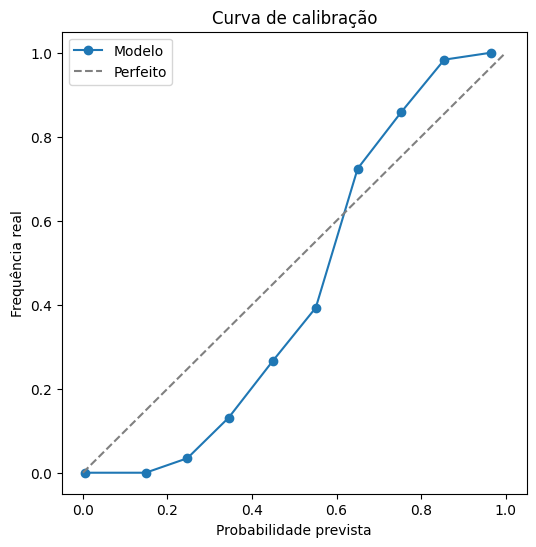

In [8]:
# Centralizado
with open("1 - LR/Centralizado/Modelo_Centralizado_LR.json", "r") as f:
    model_json = json.load(f)

ModelClass = model_classes[model_json["class"]]
model_lr = ModelClass(**model_json["params"])

if model_json["coef"] is not None:
    model_lr.coef_ = np.array(model_json["coef"])
if model_json["intercept"] is not None:
    model_lr.intercept_ = np.array(model_json["intercept"])
model_lr.classes_ = np.unique(y)

print("\nRegressão logística centralizado:")
best_thr, best_f1 = find_best_threshold(model_lr, Xs_test, y, metric="f1")
print(f"Melhor threshold: {best_thr:.2f}, com F1: {best_f1:.4f}")

y_test_prob = model_lr.predict_proba(Xs_test)[:, 1] # Probabilidade da classe positiva(Possui problema cardíaco)
y_pred = (y_test_prob >= best_thr).astype(int)

print(classification_report(y, y_pred))
print(f"Acurácia: {accuracy_score(y, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y, y_pred))

#Curva de calibração
prob_true, prob_pred = calibration_curve(y, y_test_prob, n_bins=10) 

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de calibração")
plt.legend()
plt.show()

######################################

#Federado
with open("1 - LR/Federado/Modelo_Federado_LR.json", "r") as f:
    model_json = json.load(f)

ModelClass = model_classes[model_json["class"]]
model_lr_fl = ModelClass(**model_json["params"])

if model_json["coef"] is not None:
    model_lr_fl.coef_ = np.array(model_json["coef"])
if model_json["intercept"] is not None:
    model_lr_fl.intercept_ = np.array(model_json["intercept"])
model_lr_fl.classes_ = np.unique(y)

print("\nRegressão logística federado:")
best_thr, best_f1 = find_best_threshold(model_lr_fl, Xs_test, y, metric="f1")
print(f"Melhor threshold: {best_thr:.2f}, com F1: {best_f1:.4f}")

y_test_prob = model_lr_fl.predict_proba(Xs_test)[:, 1]
y_pred = (y_test_prob >= best_thr).astype(int)

print(classification_report(y, y_pred))
print(f"Acurácia: {accuracy_score(y, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y, y_pred))    

#Curva de calibração
prob_true, prob_pred = calibration_curve(y, y_test_prob, n_bins=10) 

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de calibração")
plt.legend()
plt.show()

# Support vector machine(SVM)


SVM centralizado:
Melhor threshold: 0.95, com F1: 0.9600
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2479
           1       0.99      0.89      0.94       974

    accuracy                           0.97      3453
   macro avg       0.98      0.94      0.96      3453
weighted avg       0.97      0.97      0.97      3453

Acurácia final do modelo: 0.9673

Matriz de Confusão:
[[2473    6]
 [ 107  867]]


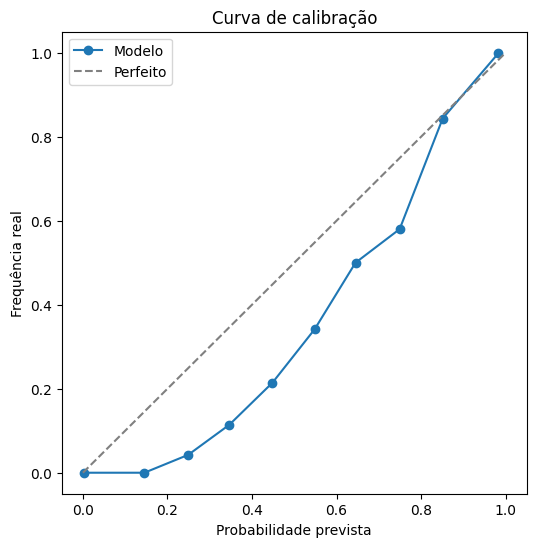


SVM federado:
Melhor threshold: 0.94, com F1: 0.8657
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2479
           1       0.90      0.86      0.88       974

    accuracy                           0.93      3453
   macro avg       0.92      0.91      0.92      3453
weighted avg       0.93      0.93      0.93      3453

Acurácia final do modelo: 0.9334

Matriz de Confusão:
[[2387   92]
 [ 138  836]]


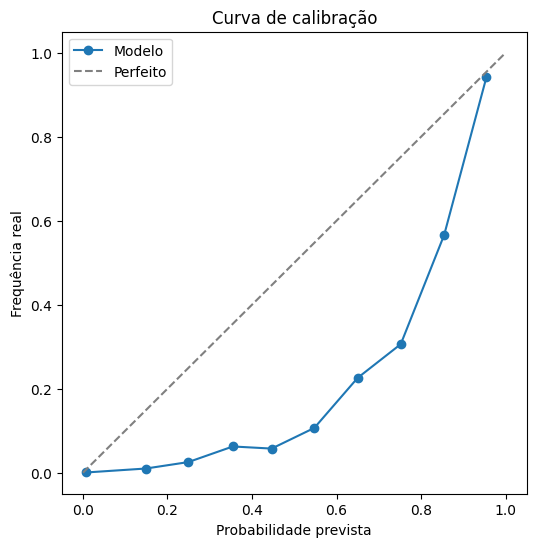

In [9]:
# Centralizado
with open("2 - SVM/Centralizado/Modelo_Centralizado_SVM.json", "r") as f:
    model_json = json.load(f)

ModelClass = model_classes[model_json["class"]]
model_svm = ModelClass(**model_json["params"])

if model_json["coef"] is not None:
    model_svm.coef_ = np.array(model_json["coef"])
if model_json["intercept"] is not None:
    model_svm.intercept_ = np.array(model_json["intercept"])
model_svm.classes_ = np.unique(y)

print("\nSVM centralizado:")
best_thr, best_f1 = find_best_threshold(model_svm, Xs_test, y, metric="f1")
print(f"Melhor threshold: {best_thr:.2f}, com F1: {best_f1:.4f}")

y_test_scores = model_svm.decision_function(Xs_test)
y_test_prob = 1 / (1 + np.exp(-np.clip(y_test_scores, -30, 30)))
y_pred = (y_test_prob >= 0.85).astype(int)

print(classification_report(y, y_pred))
print(f"Acurácia final do modelo: {accuracy_score(y, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y, y_pred))    

#Curva de calibração
prob_true, prob_pred = calibration_curve(y, y_test_prob, n_bins=10) 

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de calibração")
plt.legend()
plt.show()

######################################

#Federado
with open("2 - SVM/Federado/Modelo_Federado_SVM.json", "r") as f:
    model_json = json.load(f)

ModelClass = model_classes[model_json["class"]]
model_svm_fl = ModelClass(**model_json["params"])

if model_json["coef"] is not None:
    model_svm_fl.coef_ = np.array(model_json["coef"])
if model_json["intercept"] is not None:
    model_svm_fl.intercept_ = np.array(model_json["intercept"])
model_svm_fl.classes_ = np.unique(y)

print("\nSVM federado:")
#Utilizando a função abaixo, o melhor threshold com base em f1 foi 0,94. Porém, usando esse valor, o recall cai para 50
best_thr, best_f1 = find_best_threshold(model_svm_fl, Xs_test, y, metric="f1")
print(f"Melhor threshold: {best_thr:.2f}, com F1: {best_f1:.4f}")

y_test_scores = model_svm_fl.decision_function(Xs_test)
y_test_prob = 1 / (1 + np.exp(-np.clip(y_test_scores, -30, 30)))
y_pred = (y_test_prob >= 0.85).astype(int)

print(classification_report(y, y_pred))
print(f"Acurácia final do modelo: {accuracy_score(y, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y, y_pred))

#Curva de calibração
prob_true, prob_pred = calibration_curve(y, y_test_prob, n_bins=10) 

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de calibração")
plt.legend()
plt.show()

# Multilayer Perceptron(MLP)


MLP centralizado:
Melhor threshold: 0.68, com F1: 0.9928
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2479
           1       1.00      0.99      0.99       974

    accuracy                           1.00      3453
   macro avg       1.00      0.99      0.99      3453
weighted avg       1.00      1.00      1.00      3453

Acurácia final do modelo: 0.9959

Matriz de Confusão:
[[2476    3]
 [  11  963]]


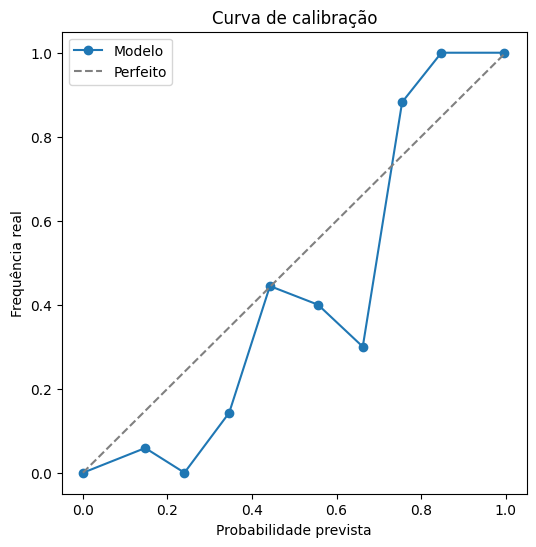


MLP federado:
Melhor threshold: 0.76, com F1: 0.9482
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2479
           1       0.96      0.94      0.95       974

    accuracy                           0.97      3453
   macro avg       0.97      0.96      0.96      3453
weighted avg       0.97      0.97      0.97      3453

Acurácia final do modelo: 0.9710

Matriz de Confusão:
[[2437   42]
 [  58  916]]


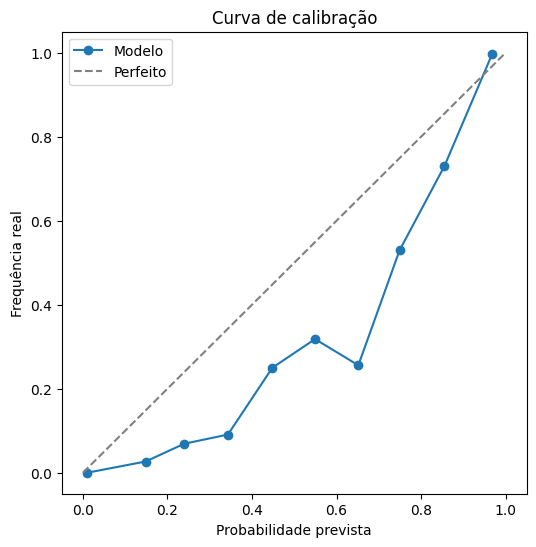

In [11]:
# Centralizado
with open("3 - MLP/Centralizado/Modelo_Centralizado_MLP.json", "r") as f:
    model_json = json.load(f)

ModelClass = model_classes[model_json["class"]]
model_mlp = ModelClass(**model_json["params"])

if model_json["coef"] is not None:
    model_mlp.coefs_ = [np.array(layer) for layer in model_json["coef"]]
if model_json["intercept"] is not None:
    model_mlp.intercepts_ =  [np.array(b) for b in model_json["intercept"]]
model_mlp.n_layers_ = len(model_mlp.coefs_) + 1  
model_mlp.n_outputs_ = model_mlp.coefs_[-1].shape[1]
model_mlp.out_activation_ = 'logistic'
model_mlp.classes_ = np.unique(y)
model_mlp.n_iter_ = 1

lb = LabelBinarizer()
lb.fit(y)  # y = array de classes da base usada
model_mlp._label_binarizer = lb

print("\nMLP centralizado:")
best_thr, best_f1 = find_best_threshold(model_mlp, Xs_test, y, metric="f1")
print(f"Melhor threshold: {best_thr:.2f}, com F1: {best_f1:.4f}")

y_test_prob = model_mlp.predict_proba(Xs_test)[:, 1]
y_pred = (y_test_prob >= best_thr).astype(int)

print(classification_report(y, y_pred))
print(f"Acurácia final do modelo: {accuracy_score(y, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y, y_pred))

#Curva de calibração
prob_true, prob_pred = calibration_curve(y, y_test_prob, n_bins=10) 

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de calibração")
plt.legend()
plt.show()

######################################

#Federado
with open("3 - MLP/Federado/Modelo_Federado_MLP.json", "r") as f:
    model_json = json.load(f)

ModelClass = model_classes[model_json["class"]]
model_mlp_fl = ModelClass(**model_json["params"])

if model_json["coef"] is not None:
    model_mlp_fl.coefs_ = [np.array(layer) for layer in model_json["coef"]]
if model_json["intercept"] is not None:
    model_mlp_fl.intercepts_ =  [np.array(b) for b in model_json["intercept"]]
model_mlp_fl.n_layers_ = len(model_mlp.coefs_) + 1
model_mlp_fl.n_outputs_ = model_mlp_fl.coefs_[-1].shape[1]
model_mlp_fl.out_activation_ = 'logistic'
model_mlp_fl.classes_ = np.unique(y)
model_mlp_fl.n_iter_ = 1

lb = LabelBinarizer()
lb.fit(y)  # y = array de classes da base usada
model_mlp_fl._label_binarizer = lb

print("\nMLP federado:")
#Utilizando a função abaixo, o melhor com base em f1 foi 0,76
best_thr, best_f1 = find_best_threshold(model_mlp_fl, Xs_test, y, metric="f1")
print(f"Melhor threshold: {best_thr:.2f}, com F1: {best_f1:.4f}")

y_test_prob = model_mlp_fl.predict_proba(Xs_test)[:, 1]
y_pred = (y_test_prob >= best_thr).astype(int)

print(classification_report(y, y_pred))
print(f"Acurácia final do modelo: {accuracy_score(y, y_pred):.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y, y_pred))

#Curva de calibração
prob_true, prob_pred = calibration_curve(y, y_test_prob, n_bins=10) 

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfeito")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência real")
plt.title("Curva de calibração")
plt.legend()
plt.show()